Notebook purpose:

- Explore whether we have login data for enough users in the main data to use logins for analysis.

Results and decision:

- We have login data for 88 percent of users, and distribution of monthly login frequency looks sensible.

In [1]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

## Load data

Main data

In [43]:
dfs, dfl = hd.read_samples(["777", "XX7"])
hd.inspect(dfl)

Time for read_sample    : 1.91 seconds
Time for read_sample    : 0.21 seconds
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


In [156]:
def drop_pre_registration_data(df):
    """Drop all transactions from before a user registered with MDB.

    MDB receives up to three years of data after a user signs up. As
    a user can obviously not log in to their MDB account during that
    time, we drop these transactions.
    """
    return df[df.date >= df.user_registration_date]


dfs = drop_pre_registration_data(dfs)
dfl = drop_pre_registration_data(dfl)

Login data

In [93]:
@hh.timer
def read_logins(nrows=None):
    fp = "s3://3di-data-mdb/raw/20200630_UserLoginsForNeedham.csv"
    return ha.read_csv(fp, nrows=nrows, names=["user_id", "date"], parse_dates=["date"])


login_data = read_logins()
hd.inspect(login_data)

Time for read_logins    : 37.96 seconds
(7,521,416, 2)


,user_id,date
0,1,2015-07-23 14:28:00
1,1,2015-07-27 05:43:00


Proportion of users in dataset with login info

In [160]:
txn_data = dfl
len(set(txn_data.user_id) & set(login_data.user_id)) / txn_data.user_id.nunique()

0.8812451960030746

Aggregate logins data to user-day level

In [166]:
def daily_logins(login_data):
    login_data = login_data.copy()
    login_data["date"] = login_data.date.dt.round("d")
    login_data["logins"] = 1
    return login_data.groupby(["user_id", "date"]).logins.sum().reset_index()


logins_daily = daily_logins(login_data)
hd.inspect(logins_daily)

(6,625,111, 3)


,user_id,date,logins
0,1,2015-07-24,1
1,1,2015-07-27,1


Merge login data into transaction data

In [162]:
def merge_logins(txn_data, login_data):
    txn_data = txn_data.copy()
    login_data = login_data.copy()
    merged = txn_data.merge(
        login_data, on=["user_id", "date"], how="left", validate="m:1"
    )
    merged["logins"] = merged.logins.fillna(0)
    return merged


txn_data = dfl
df = merge_logins(txn_data, logins_daily)
hd.inspect(df)

(9,539,059, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac,logins
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209,0.0
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209,0.0


## Explore logins

### User level

In [168]:
def user_logins(df, freq="m"):
    period = pd.Grouper(key="date", freq=freq)
    return (
        df.groupby(["user_id", period])
        .logins.sum()
        .groupby(["user_id"])
        .agg(["mean", "median", "std", "sum", "size"])
    )


logins_user = user_logins(df)
hd.inspect(logins_user)

(5,204, 5)


,mean,median,std,sum,size
user_id,,,,,
57,8.160000,0.0,13.754500,816.0,100
107,11.605263,1.0,25.055181,882.0,76


In [169]:
logins_user.describe()

,mean,median,std,sum,size
count,5204.000000,5204.000000,4992.000000,5204.000000,5204.000000
mean,6.809477,4.682840,7.701427,109.041507,18.873751
std,13.708230,13.135486,11.108252,362.462056,19.204074
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.206643,0.000000,0.707107,2.000000,5.000000
50%,1.838542,0.000000,3.714036,15.000000,11.000000
75%,6.893939,3.000000,10.035591,64.000000,25.000000
max,180.625000,181.500000,123.036580,7125.000000,100.000000


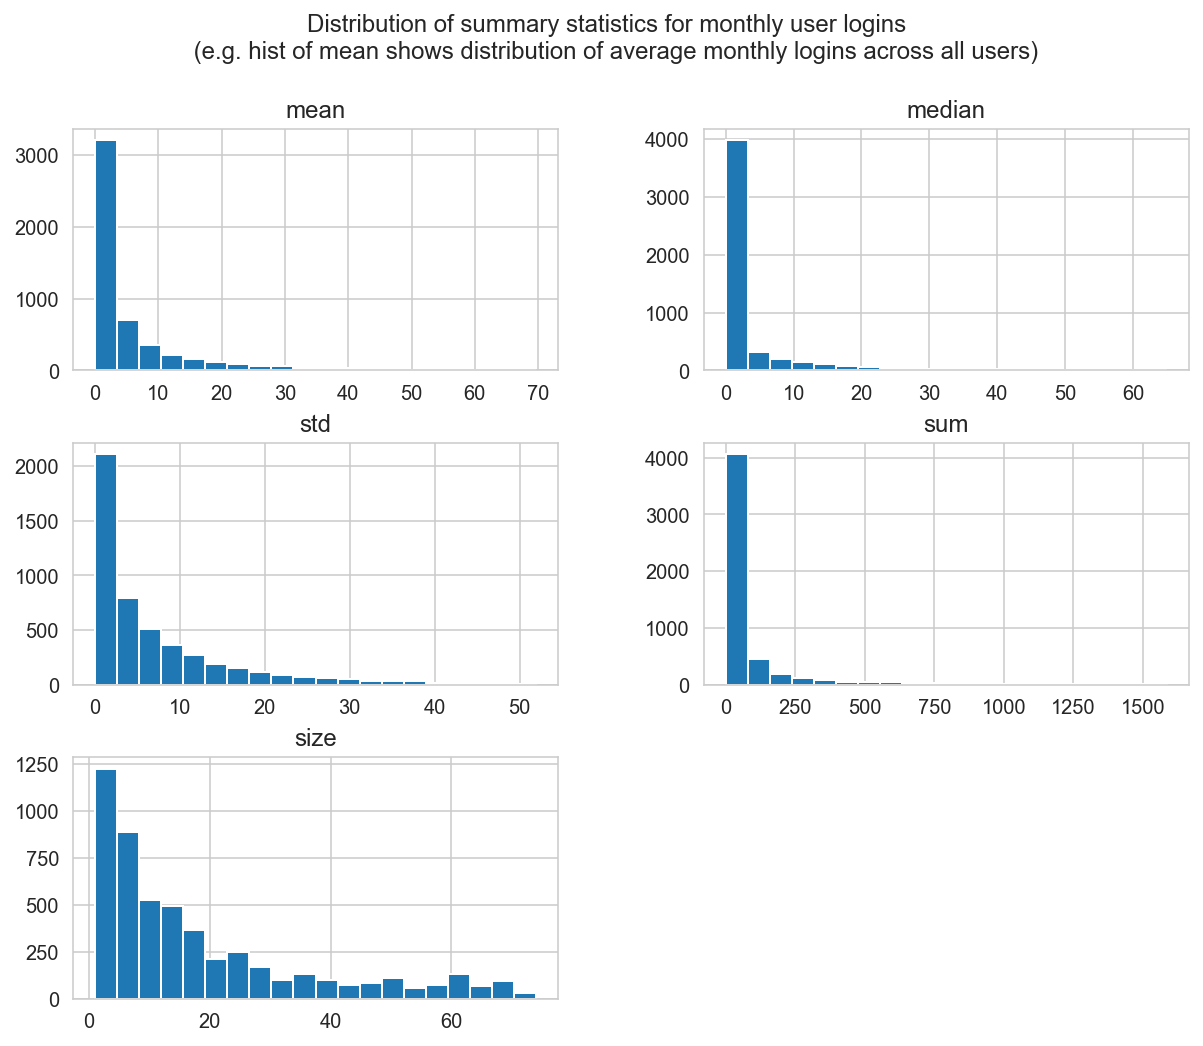

In [206]:
logins_user.apply(hd.trim, pct=1).hist(bins=20, figsize=(10, 8))
plt.suptitle(
    "Distribution of summary statistics for monthly user logins "
    " \n (e.g. hist of mean shows distribution of average monthly"
    " logins across all users)"
);